In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = "data/dogs-vs-cats/"

batch_size = 32
img_height = 180
img_width = 180


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


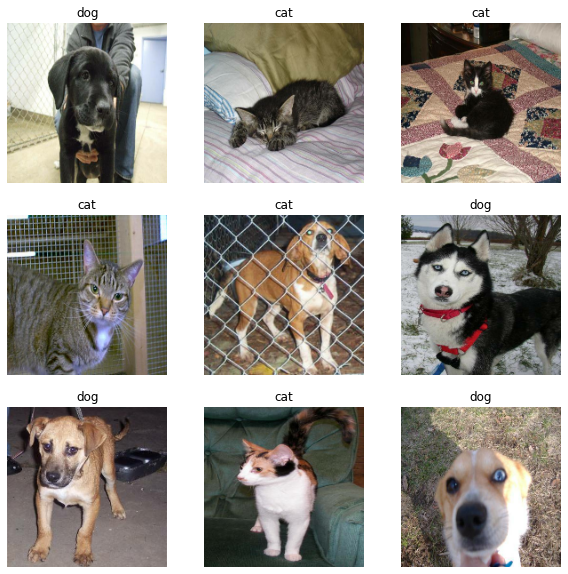

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.011697817 0.99984753


In [10]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

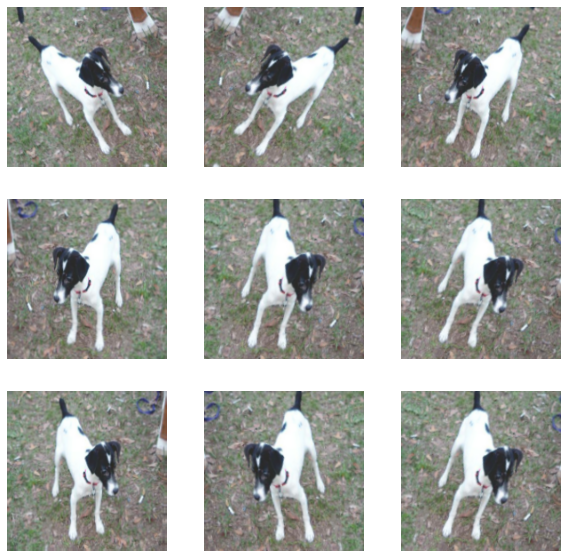

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
model = Sequential([
  data_augmentation, # <= image augmentation
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # <= before training
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [19]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
250/250 [==============================] - 167s 661ms/step - loss: 0.7014 - accuracy: 0.5635 - val_loss: 0.6505 - val_accuracy: 0.6375
Epoch 2/15
250/250 [==============================] - 140s 558ms/step - loss: 0.6311 - accuracy: 0.6491 - val_loss: 0.5943 - val_accuracy: 0.6930
Epoch 3/15
250/250 [==============================] - 133s 534ms/step - loss: 0.5918 - accuracy: 0.6865 - val_loss: 0.5702 - val_accuracy: 0.7115
Epoch 4/15
250/250 [==============================] - 143s 571ms/step - loss: 0.5615 - accuracy: 0.7111 - val_loss: 0.5558 - val_accuracy: 0.7255
Epoch 5/15
250/250 [==============================] - 138s 550ms/step - loss: 0.5379 - accuracy: 0.7304 - val_loss: 0.5294 - val_accuracy: 0.7395
Epoch 6/15
250/250 [==============================] - 128s 510ms/step - loss: 0.5111 - accuracy: 0.7473 - val_loss: 0.4947 - val_accuracy: 0.7675
Epoch 7/15
250/250 [==============================] - 124s 497ms/step - loss: 0.4930 - accuracy: 0.7630 - val_loss: 0.5088 -

In [20]:
model

In [21]:
import pickle

In [22]:
pickle.dump(model, open('model.pkl', 'wb'))

In [23]:
pickled_model = pickle.load(open('model.pkl', 'rb'))

In [24]:
pickled_model

In [30]:
unseen_cat_path = "data/unseen-cat.jpeg"
unseen_dog_path = "data/unseen-dog.jpg"

img_to_predict_path = unseen_cat_path

img = tf.keras.utils.load_img(
    img_to_predict_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch

predictions = pickled_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to '{}' with a '{:.2f}%' confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 175ms/step
This image most likely belongs to 'cat' with a '99.69%' confidence.
